In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pycocotools opencv-python tqdm tensorboard tensorboardX pyyaml matplotlib webcolors
!pip install numpy==1.17.5 # Downgrade numpy because coco API doesn't work with numpy 1.18
!pip install torch==1.4.0
!pip install torchvision==0.5.0

In [ ]:
%%shell

export PATH=/usr/local/cuda-10.1/bin:$PATH
nvcc --version

# Install NVIDIA Apex
git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

## Get weights

In [ ]:
%%shell
cd drive/My\ Drive/Untitled\ folder/CellarEye/Training\ Notebooks/EfficientDet_PyTorch_Object_Detection/
mkdir -p weights
cd weights

# Add all the checkpoints you need here:
wget --no-clobber https://github.com/zylo117/Yet-Another-Efficient-Pytorch/releases/download/1.0/efficientdet-d1.pth
wget --no-clobber https://github.com/zylo117/Yet-Another-Efficient-Pytorch/releases/download/1.0/efficientdet-d2.pth
wget --no-clobber https://github.com/zylo117/Yet-Another-Efficient-Pytorch/releases/download/1.0/efficientdet-d3.pth
wget --no-clobber https://github.com/zylo117/Yet-Another-Efficient-Pytorch/releases/download/1.0/efficientdet-d4.pth

## Decompress dataset (Helper)

In [ ]:
%%shell
cd drive/My\ Drive/Untitled\ folder/CellarEye/Training\ Notebooks/EfficientDet_PyTorch_Object_Detection/datasets

# -n flag ensues that files aren't overwritten.
#unzip -n dataset-013-640.zip 
#unzip -n dataset-013-768.zip 
#unzip -n dataset-013-896.zip 
#unzip -n dataset-013-1024.zip 
#unzip -n dataset-014-768.zip
#unzip -n dataset-014-896.zip
#unzip -n dataset-014-640.zip

#cd dataset-014-896

find . -maxdepth 1 -mindepth 1 -type d | while read dir; do
  printf "%-25.25s : " "$dir"
  find "$dir" -type f | wc -l
done

In [ ]:
# If you want to make sure files are saved
#drive.flush_and_unmount()

#### Test the environment

In [ ]:
#cd drive/My\ Drive/Untitled\ folder/CellarEye/Training\ Notebooks/EfficientDet_PyTorch_Object_Detection/
!python efficientdet_test.py
!echo "--------"
!nvidia-smi

## Training

Here we can test with different learning rates. We will also have to try with different values for c (i.e. D0-D7), and number of epochs.

For an exploration run 1 epoch, c=3, and the default values make sense.

Also, if you don't want to freeze the backbone: remove `--head-only True`

In [ ]:
%%shell
DATASET='dataset-014-896'

case $DATASET in
  'dataset-003' | 'dataset-013-640' | 'dataset-014-640')
    LOADED_WEIGHTS='weights/efficientdet-d1.pth'
    COEF=1
    ;;
  'dataset-013-768' | 'dataset-014-768')
    LOADED_WEIGHTS='weights/efficientdet-d2.pth'
    COEF=2
    ;;
  'dataset-011' | 'dataset-013-896' | 'dataset-014-896')
    LOADED_WEIGHTS='weights/efficientdet-d3.pth'
    COEF=3
    ;;
  'dataset-012' | 'dataset-013-1024')
    LOADED_WEIGHTS='weights/efficientdet-d4.pth'
    COEF=4
    ;;
  *)
    echo -n 'Unknown configuration'
    ;;
esac

EPOCHS=80
LR=1e-5
BATCH_SIZE=8
SAVE_INTERVAL=2000
APEX=True

# Load latest checkpoint
#LOADED_WEIGHTS=last

cd drive/My\ Drive/Untitled\ folder/CellarEye/Training\ Notebooks/EfficientDet_PyTorch_Object_Detection/

if [ ${APEX} != False ]; then
  echo 'Using Apex for FP16';
  LOG_PATH='logs/apex/'
  SAVED_PATH=$LOG_PATH

  python train_apex.py --compound_coef $COEF --batch_size $BATCH_SIZE --lr $LR --num_epochs $EPOCHS --load_weights $LOADED_WEIGHTS --head_only True --project $DATASET --save_interval $SAVE_INTERVAL \
  --apex \
  --log_path $LOG_PATH \
  --saved_path $SAVED_PATH
else
  python train_apex.py --compound_coef $COEF --batch_size $BATCH_SIZE --lr $LR --num_epochs $EPOCHS --load_weights $LOADED_WEIGHTS --head_only True --project $DATASET --save_interval $SAVE_INTERVAL
fi

In [ ]:
#drive.flush_and_unmount()

## Evaluation

### Config

In [1]:
# PROJECT_PATH = 'drive/My Drive/Untitled folder/CellarEye/Training Notebooks/EfficientDet_PyTorch_Object_Detection'
PROJECT_PATH = '.'

import sys
sys.path.append(PROJECT_PATH)

import time

import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

try:
    from apex.fp16_utils import *
    from apex import amp, optimizers
except ImportError:
    raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

# input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
CONFIG = {
  '003': {
    'compound_coef': 1,
    'input_size': 640,
    'weights': 'dataset-003/efficientdet-d1_49_22800.pth',
    'obj_list': ['bottle_cap', 'bottle', 'cap']
  },
  '011': {
    'compound_coef': 3,
    'input_size': 896,
    'weights': 'dataset-011/efficientdet-d3_49_20500.pth',
    'obj_list': ['bottle_cap', 'bottle', 'cap']
  },
  '012': {
    'compound_coef': 4,
    'input_size': 1024,
    'weights': 'dataset-012/efficientdet-d4_49_17500.pth',
    'obj_list': ['bottle_cap', 'bottle', 'cap']
  },
  '013-640': {
    'compound_coef': 1,
    'input_size': 640,
    'weights': 'dataset-013-640/efficientdet-d1_49_127350.pth',
    'obj_list': ['cap', 'bottle_cap', 'bottle', 'wine_label', 'human_hand']
  },
  '013-768': {
    'compound_coef': 2,
    'input_size': 768,
    'weights': 'dataset-013-768/efficientdet-d2_59_149000.pth',
    'obj_list': ['cap', 'bottle_cap', 'bottle', 'wine_label', 'human_hand']
  },
  '013-896': {
    'compound_coef': 3,
    'input_size': 896,
    'weights': 'dataset-013-896/efficientdet-d3_46_116090.pth',
    'obj_list': ['cap', 'bottle_cap', 'bottle', 'wine_label', 'human_hand']
  },
  '013-1024': {
    'compound_coef': 4,
    'input_size': 1024,
    'weights': 'dataset-013-1024/efficientdet-d4_30_76787.pth',
    'obj_list': ['cap', 'bottle_cap', 'bottle', 'wine_label', 'human_hand']
  },
    '014-640': {
    'compound_coef': 1,
    'input_size': 640,
    'weights': 'dataset-014-640/efficientdet-d1_43_78628.pth',
    'obj_list': ['cap', 'bottle_cap', 'bottle', 'wine_label', 'human_hand']
  },
  '014-768': {
    'compound_coef': 2,
    'input_size': 768,
    'weights': 'dataset-014-768/efficientdet-d2_43_76000.pth',
    'obj_list': ['cap', 'bottle_cap', 'bottle', 'wine_label', 'human_hand']
  },
  '014-896': {
    'compound_coef': 3,
    'input_size': 896,
    'weights': 'dataset-014-896/efficientdet-d3_28_50000.pth',
    'weights_apex': 'apex/dataset-014-896/efficientdet-d3_8_14000.pth',
    'obj_list': ['cap', 'bottle_cap', 'bottle', 'wine_label', 'human_hand']
  },
}

# replace this part with your project's anchor config
anchor_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

threshold = 0.2
iou_threshold = 0.2

force_input_size = None  # set None to use default size
use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

### Helpers

In [2]:
def display(preds, imgs, obj_list, imshow=True, imwrite=False):          
  for i in range(len(imgs)):
    if len(preds[i]['rois']) == 0:
      continue

    for j in range(len(preds[i]['rois'])):
      (x1, y1, x2, y2) = preds[i]['rois'][j].astype(np.int)
      cv2.rectangle(imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
      obj = obj_list[preds[i]['class_ids'][j]]
      score = float(preds[i]['scores'][j])

      cv2.putText(imgs[i], '{}, {:.3f}'.format(obj, score),
                  (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                  (255, 255, 0), 1)

    if imshow:
      plt.imshow(imgs[i])

    if imwrite:
      cv2.imwrite(f'dataset-003/img_inferred_d{compound_coef}_this_repo_{i}.jpg', imgs[i])
    
def preprocess_image(img_path, input_size, use_cuda):
  ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

  if use_cuda:
      x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
  else:
      x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

  x = x.to(torch.float32).permute(0, 3, 1, 2)

  return ori_imgs, x, framed_metas

def load_model(model_path, compound_coef, obj_list, anchor_ratios, anchor_scales, use_cuda):
  model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             ratios=anchor_ratios, scales=anchor_scales)
  model.load_state_dict(torch.load(model_path))
  model.requires_grad_(False)
  model.eval()

  if use_cuda:
      model = model.cuda()
  
  return model

def load_apex_model(model_path, compound_coef, obj_list, anchor_ratios, anchor_scales):
  device = 'cuda'
  opt_level = 'O1'

  model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                            ratios=anchor_ratios, scales=anchor_scales)
  checkpoint = torch.load(model_path)
  
  model = model.to(device)
  optimizer = torch.optim.AdamW(model.parameters(), 1e-4)
  model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  amp.load_state_dict(checkpoint['amp'])
  
  model.requires_grad_(False)
  model.to(device)
  model = model.eval()
  
  return model

def annotate_image(model, x, framed_metas, with_postprocess=True):
  with torch.no_grad():
    features, regression, classification, anchors = model(x)

    if with_postprocess:
      regressBoxes = BBoxTransform()
      clipBoxes = ClipBoxes()

      out = postprocess(x,
                        anchors, regression, classification,
                        regressBoxes, clipBoxes,
                        threshold, iou_threshold)

      out = invert_affine(framed_metas, out)
    else:
      out = None
  return out

def process_image(dataset_id, display_image=True, use_apex=False, CONFIG=CONFIG, PROJECT_PATH=PROJECT_PATH):
  compound_coef = CONFIG[dataset_id]['compound_coef']
  obj_list = CONFIG[dataset_id]['obj_list']
  input_size = CONFIG[dataset_id]['input_size'] if force_input_size is None else force_input_size
  img_path = f"{PROJECT_PATH}/datasets/dataset-{dataset_id}/test{dataset_id}/mojtaba65_crp_3.jpg"
  model_path = f"{PROJECT_PATH}/logs/{CONFIG[dataset_id]['weights']}"

  ori_imgs, x, framed_metas = preprocess_image(img_path, input_size, use_cuda)
  
  if use_apex:
    model_path = f"{PROJECT_PATH}/logs/{CONFIG[dataset_id]['weights_apex']}" 
  else:
    model_path = f"{PROJECT_PATH}/logs/{CONFIG[dataset_id]['weights']}"

  ori_imgs, x, framed_metas = preprocess_image(img_path, input_size, use_cuda)

  if use_apex:
    model = load_apex_model(model_path, compound_coef, obj_list, anchor_ratios, anchor_scales)
  else:
    model = load_model(model_path, compound_coef, obj_list, anchor_ratios, anchor_scales, use_cuda)

  out = annotate_image(model, x, framed_metas)
  
  if display_image:
    display(out, ori_imgs, obj_list)
  
  return out, model, x, framed_metas

def inference_time(models, TIMES=20, use_apex=False, CONFIG=CONFIG):
  for dataset_id in models:
    # Load model and do a first inference to initialize
    _, model, x, framed_metas = process_image(dataset_id, display_image=False, use_apex=use_apex)

    # Start inference
    t1 = time.time()
    for _ in range(TIMES):
      annotate_image(model, x, framed_metas)
    t2 = time.time()
    tact_time = (t2 - t1) / TIMES
    print(f"Speed test of model D{CONFIG[dataset_id]['compound_coef']} with dataset-{dataset_id} using apex: {use_apex}")
    print(f'{tact_time} seconds, {1 / tact_time} FPS, @batch_size 1')
    print()

def inference_performance(models, dataset='val', use_apex=False, CONFIG=CONFIG):
  for dataset_id in models:
    project_name = f"dataset-{dataset_id}"
    compound_coef = CONFIG[dataset_id]['compound_coef']
    if use_apex:
      trained_weights = f"{PROJECT_PATH}/logs/{CONFIG[dataset_id]['weights_apex']}"
      !python coco_eval.py -p $project_name -c $compound_coef -w $trained_weights -d $dataset --apex
    else:
      trained_weights = f"{PROJECT_PATH}/logs/{CONFIG[dataset_id]['weights']}"
      !python coco_eval.py -p $project_name -c $compound_coef -w $trained_weights -d $dataset

### Visualization

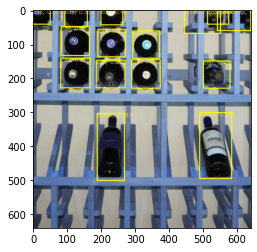

In [3]:
_, _, _, _ = process_image('014-640', display_image=True, use_apex=False)

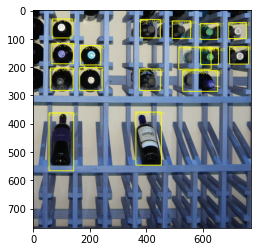

In [4]:
_, _, _, _ = process_image('014-768', display_image=True, use_apex=False)

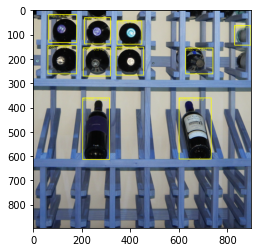

In [5]:
_, _, _, _ = process_image('014-896', display_image=True, use_apex=False)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


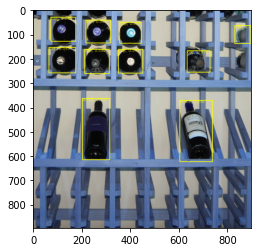

In [6]:
_, _, _, _ = process_image('014-896', display_image=True, use_apex=True)

## FP32
---
### Evaluation

In [7]:
!nvidia-smi

# Models to evaluate with
models = ['014-640', '014-768', '014-896']

Mon May 11 16:38:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 166...  Off  | 00000000:09:00.0  On |                  N/A |
|  0%   48C    P2    40W / 125W |   2137MiB /  5941MiB |     85%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Inference Time

In [ ]:
inference_time(models)

#### Inference Accuracy

In [12]:
inference_performance(models, dataset='val')

running coco-style evaluation on project dataset-014-640, weights ./logs/dataset-014-640/efficientdet-d1_43_78628.pth...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
100%|███████████████████████████████████████| 1589/1589 [01:18<00:00, 20.27it/s]
Loading and preparing results...
DONE (t=1.18s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.29s).
Accumulating evaluation results...
DONE (t=0.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.55141
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.85371
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.60343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.00000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.53220
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.52643
 Ave

## Apex
---
### Evaluation

In [ ]:
# Models to evaluate with
models = ['014-896']

#### Inference Time

In [ ]:
inference_time(models, use_apex=True)

#### Inference Accuracy

In [ ]:
inference_performance(models, dataset='val', use_apex=True)